In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

2023-08-02 07:11:50.780030: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 07:11:50.855494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 07:11:50.856632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 07:11:52.377123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.12.0


/tmp/ipykernel_31543/3597915037.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Hyperparameters

In [2]:
seq_len = 128

## Load IBM price and volume data

In [3]:
IBM_path = 'IBM.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,1988-08-01,30.114723,30.234226,29.965343,30.174475,4544242
1,1988-08-02,30.234226,30.323853,29.786091,30.054972,5599866
2,1988-08-03,30.054972,30.234226,29.995220,30.054972,8039138
3,1988-08-04,29.995220,29.995220,29.636711,29.696463,4660139
4,1988-08-05,29.547085,29.696463,29.517208,29.606836,3016664


## Plot daily IBM closing prices

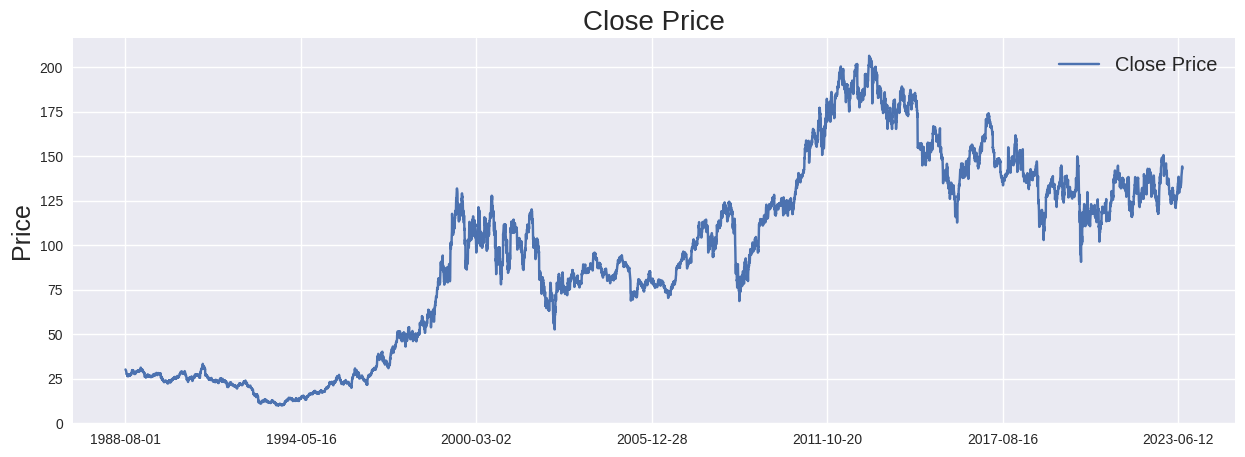

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

## Plot daily IBM volumes

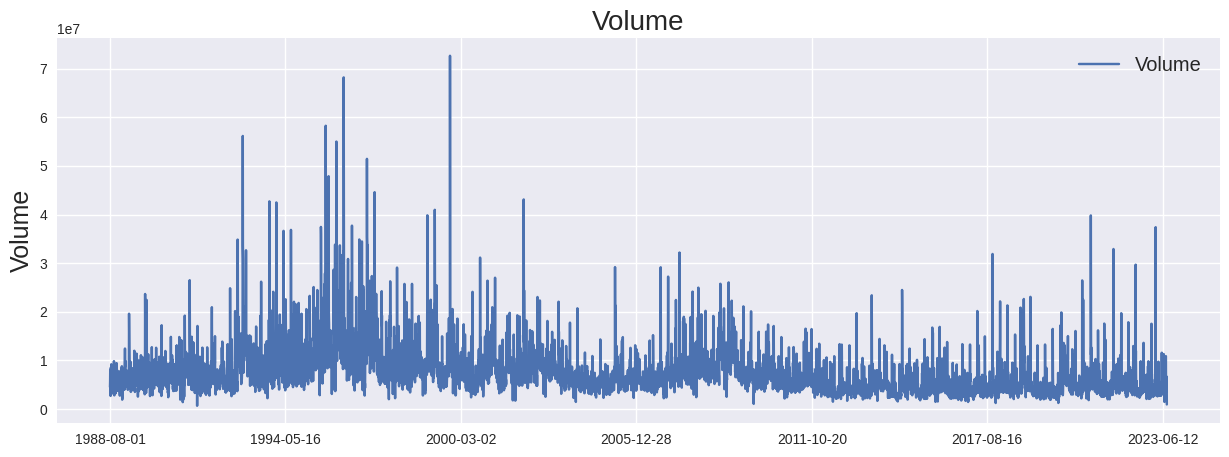

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Calculate normalized percentage change for all columns

In [6]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (7055, 5)
Validation data shape: (882, 5)
Test data shape: (881, 5)


,Open,High,Low,Close,Volume
1,0.526808,0.523893,0.497914,0.503784,0.110041
2,0.498068,0.506702,0.535673,0.515285,0.129274
3,0.509512,0.492329,0.480577,0.480646,0.048303
4,0.471900,0.486362,0.503576,0.506521,0.054703
5,0.518221,0.518206,0.506467,0.497703,0.078356


## Plot daily changes of close prices and volume

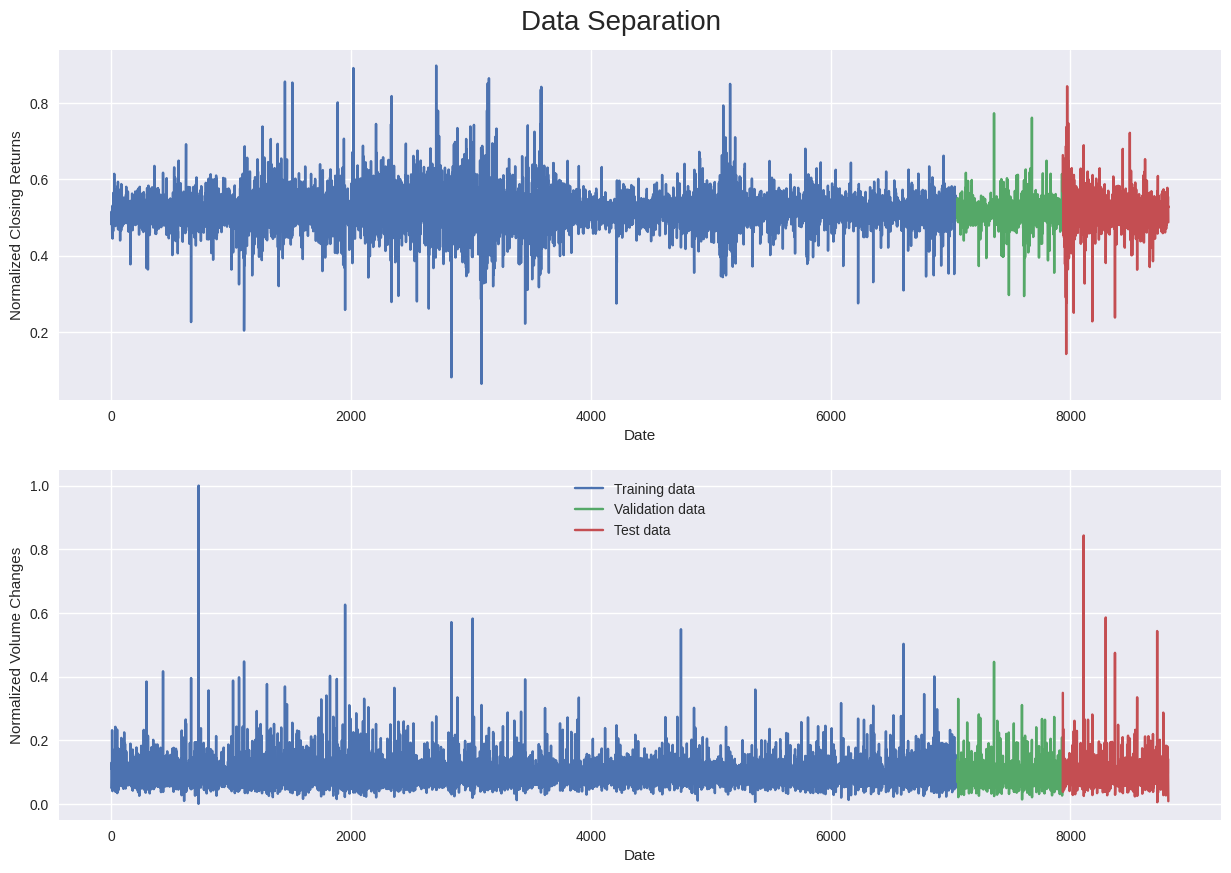

In [7]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Create chunks of training, validation and test data

In [8]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6927, 128, 5) (6927,)
(754, 128, 5) (754,)


## 1D Convolution layers for a CNN+LSTM model

In [9]:
def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)
  
  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)  
  
  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3) 
  
  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)  
  
  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)  
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)    
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)   
  
  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)
  
  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)   
  
  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)   
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)  
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)  
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)   

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl) 
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  
  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)  
  
  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

# **Testing different model architectures**

### Bi-LSTM model

In [11]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

#model = tf.keras.models.load_model('/content/Bi-LSTM.hdf5')
model = tf.keras.models.load_model('/Bi-LSTM.hdf5')



###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')

plt.tight_layout()
plt.legend(loc='best')

2023-08-02 10:27:30.977946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-02 10:27:30.980347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-02 10:27:30.982378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-08-02 10:27:32.645850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-02 10:27:32.648475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-02 10:27:32.650072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.02650, saving model to Bi-LSTM.hdf5
4/4 - 80s - loss: 0.0858 - mae: 0.2492 - mape: 48.7922 - val_loss: 0.0265 - val_mae: 0.1586 - val_mape: 30.4570 - 80s/epoch - 20s/step
Epoch 2/200

Epoch 2: val_loss improved from 0.02650 to 0.00493, saving model to Bi-LSTM.hdf5
4/4 - 65s - loss: 0.0139 - mae: 0.1007 - mape: 19.7773 - val_loss: 0.0049 - val_mae: 0.0616 - val_mape: 12.5169 - 65s/epoch - 16s/step
Epoch 3/200

Epoch 3: val_loss improved from 0.00493 to 0.00237, saving model to Bi-LSTM.hdf5
4/4 - 66s - loss: 0.0065 - mae: 0.0668 - mape: 13.0752 - val_loss: 0.0024 - val_mae: 0.0388 - val_mape: 7.4515 - 66s/epoch - 16s/step
Epoch 4/200

Epoch 4: val_loss improved from 0.00237 to 0.00164, saving model to Bi-LSTM.hdf5
4/4 - 65s - loss: 0.0048 - mae: 0.0548 - mape: 11.2150 - val_loss: 0.0016 - val_mae: 0.0274 - val_mape: 5.6141 - 65s/epoch - 16s/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.00164
4/4 - 64s - loss: 0.0040 - mae: 0.0483 - m

OSError: No file or directory found at /Bi-LSTM.hdf5

### CNN + Bi-LSTM model

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00590, saving model to CNN+Bi-LSTM.hdf5
6/6 - 5s - loss: 0.0054 - mae: 0.0539 - mape: 9.3209 - val_loss: 0.0059 - val_mae: 0.0719 - val_mape: 11.9411
Epoch 2/200

Epoch 00002: val_loss improved from 0.00590 to 0.00396, saving model to CNN+Bi-LSTM.hdf5
6/6 - 2s - loss: 0.0018 - mae: 0.0315 - mape: 5.6412 - val_loss: 0.0040 - val_mae: 0.0573 - val_mape: 9.4896
Epoch 3/200

Epoch 00003: val_loss improved from 0.00396 to 0.00282, saving model to CNN+Bi-LSTM.hdf5
6/6 - 2s - loss: 0.0017 - mae: 0.0296 - mape: 5.3167 - val_loss: 0.0028 - val_mae: 0.0467 - val_mape: 7.7159
Epoch 4/200

Epoch 00004: val_loss improved from 0.00282 to 0.00249, saving model to CNN+Bi-LSTM.hdf5
6/6 - 2s - loss: 0.0016 - mae: 0.0284 - mape: 5.1324 - val_loss: 0.0025 - val_mae: 0.0432 - val_mape: 7.1387
Epoch 5/200

Epoch 00005: val_loss improved from 0.00249 to 0.00194, saving model to CNN+Bi-LSTM.hdf5
6/6 - 2s - loss: 0.0016 - mae: 0.0280 - mape: 5.0601 - va

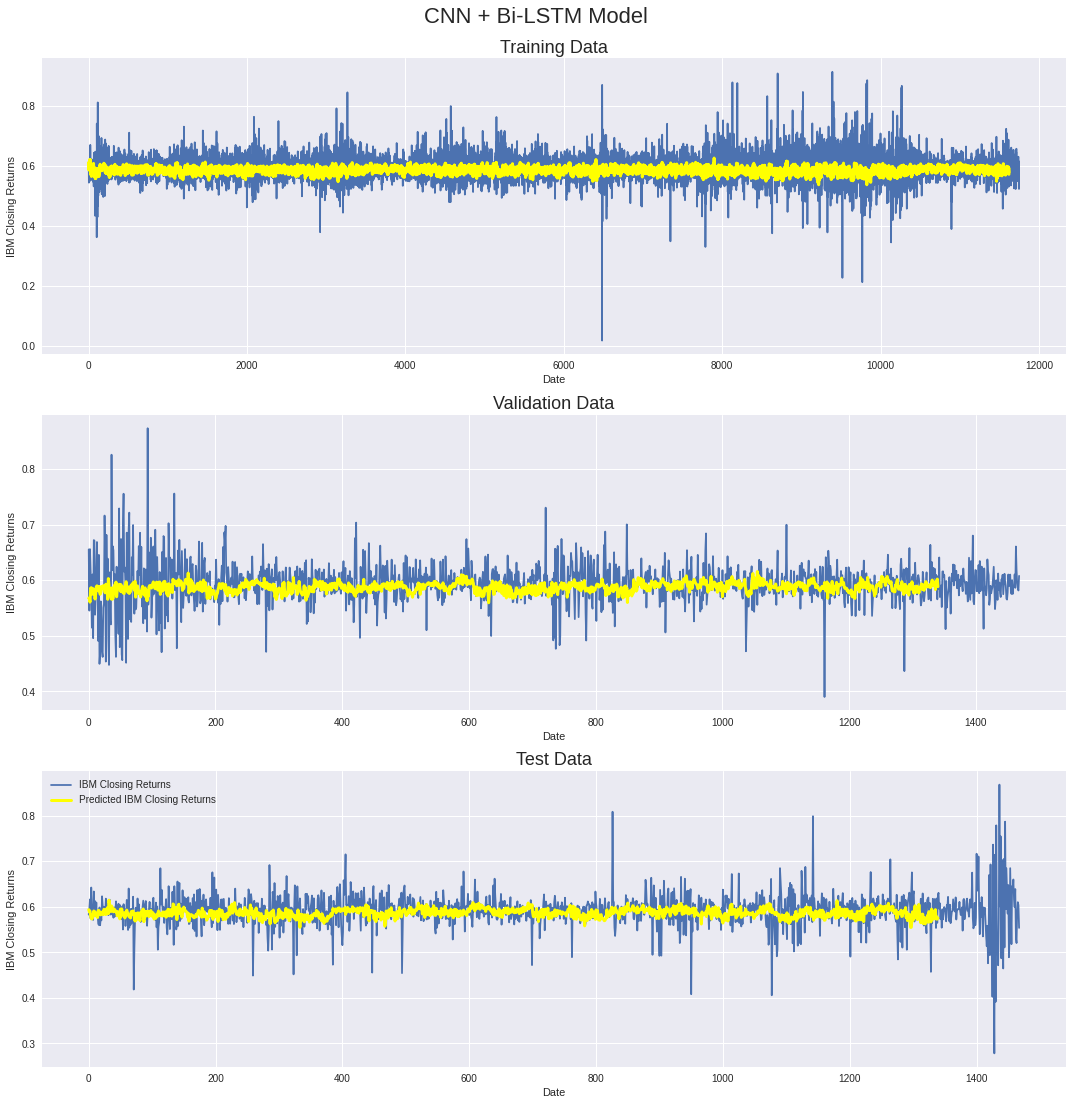

In [ ]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/CNN+Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

## **Conculsion 1**
When interpreting at the evaluation metrics it seems that the networks are predicting the next day closing price returns very well. The Bi-LSTM and CNN+Bi-LSTM networks have a **mean average percentage error** **(MAPE)** of  `3.58` and `3.84` for the validation set and `4.26` and `4.53` for the test set. 
Making it also obvious that the Bi-LSTM network is better than the CNN+Bi-LSTM network, which honestly surprised me.

However, when taking a glance at the graphs of the validation and test set it becomes clear that the networks have merely found the center point of the return distributions. Over the entire course of the time series the networks do not divert greatly from the center.

It seems that the right and left tail of the stock return distribution are not derivable from price data alone.

I do have the following **hypotheses** that provide more room for investigation and might lead to better results.

#### **Hypotheses**

1. The stock returns seem very rugged, which could make the networks interpret the distribution tails as semi-random. --> smooth returns with **moving average**

2. We do need more price data to derive temporal dependencies of the time series and get a better understanding of the distribution tails. --> Obtain **more price data** of different stocks, etfs, etc.

3. In order to predict the stock return distribution tails more accurately include additional features e.g. **financial news, company's balance sheet and P&L**

The first hypothesis we'll also implement in this notebook.

The second and third hypothesis will be addressed at a later stage.




# **Moving Average Analysis**

## Loading IBM data again to apply a moving average effect

In [ ]:
IBM_path = 'IBM.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

df.head()

,Date,Open,High,Low,Close,Volume
9,1962-01-15,7.540000,7.578333,7.488667,7.515000,363040.0
10,1962-01-16,7.523333,7.561667,7.473333,7.499667,349440.0
11,1962-01-17,7.504667,7.536333,7.444000,7.465667,362560.0
12,1962-01-18,7.472667,7.511667,7.420000,7.441333,374080.0
13,1962-01-19,7.449333,7.490333,7.404000,7.432667,377760.0


## Moving Average - Plot daily IBM closing prices

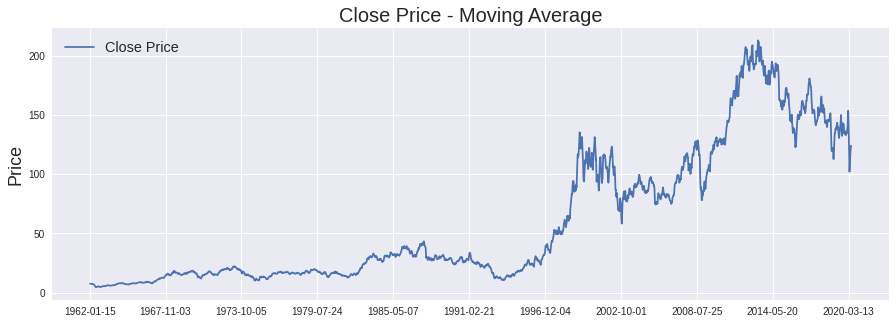

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Plot daily IBM volumes

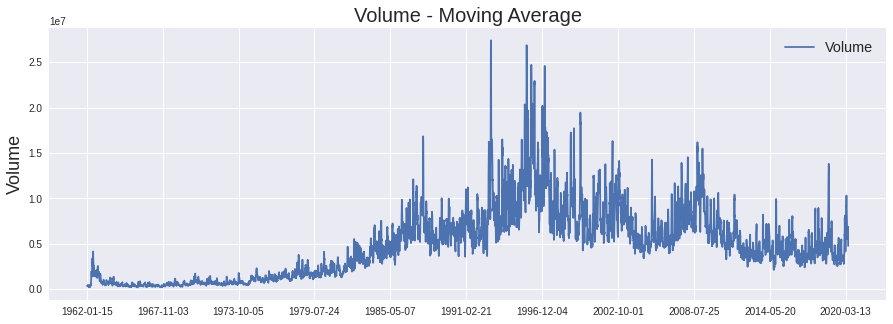

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume - Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (11743, 5)
Validation data shape: (1468, 5)
Test data shape: (1467, 5)


,Open,High,Low,Close,Volume
10,0.516547,0.516711,0.518941,0.519047,0.305158
11,0.512567,0.499793,0.491343,0.482399,0.363778
12,0.486361,0.500928,0.501647,0.501128,0.359267
13,0.503140,0.507292,0.517342,0.531919,0.342123
14,0.533253,0.547731,0.567569,0.556950,0.278825


## Moving Average - Plot daily changes of close prices and volume

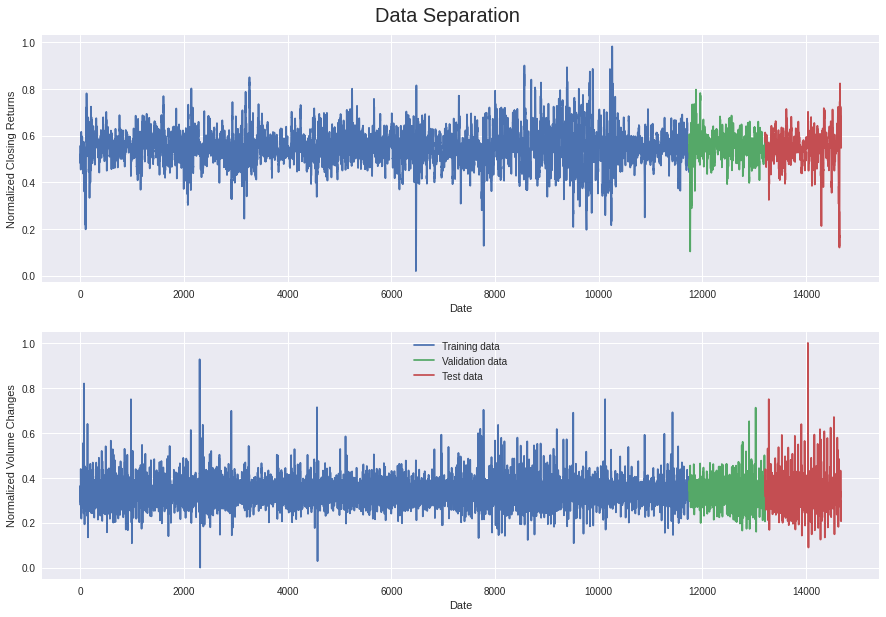

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Moving Average - Create chunks of training, validation and test data

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11615, 128, 5) (11615,)
(1340, 128, 5) (1340,)


# **Moving Average - Testing different model architectures**

### Moving Average - Bi-LSTM model

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00272, saving model to Bi-LSTM.hdf5
6/6 - 3s - loss: 0.0068 - mae: 0.0636 - mape: 12.2175 - val_loss: 0.0027 - val_mae: 0.0404 - val_mape: 7.4661
Epoch 2/200

Epoch 00002: val_loss improved from 0.00272 to 0.00264, saving model to Bi-LSTM.hdf5
6/6 - 2s - loss: 0.0054 - mae: 0.0544 - mape: 10.6212 - val_loss: 0.0026 - val_mae: 0.0395 - val_mape: 7.2039
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.00264
6/6 - 2s - loss: 0.0053 - mae: 0.0539 - mape: 10.5285 - val_loss: 0.0026 - val_mae: 0.0394 - val_mape: 7.1218
Epoch 4/200

Epoch 00004: val_loss improved from 0.00264 to 0.00262, saving model to Bi-LSTM.hdf5
6/6 - 2s - loss: 0.0052 - mae: 0.0537 - mape: 10.4788 - val_loss: 0.0026 - val_mae: 0.0393 - val_mape: 7.1212
Epoch 5/200

Epoch 00005: val_loss did not improve from 0.00262
6/6 - 2s - loss: 0.0052 - mae: 0.0534 - mape: 10.4399 - val_loss: 0.0026 - val_mae: 0.0392 - val_mape: 7.0779
Epoch 6/200

Epoch 00006: val_lo

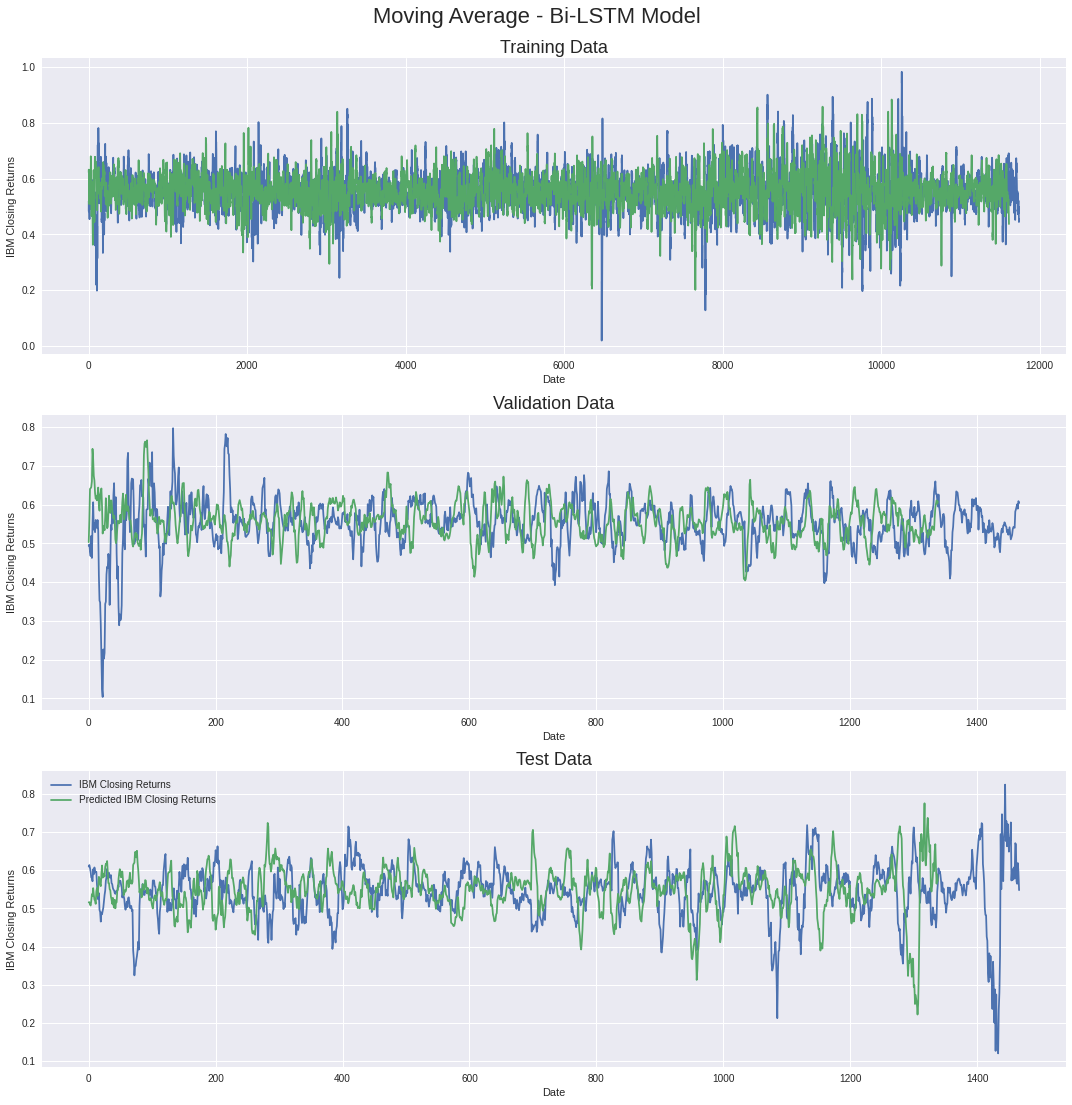

In [ ]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/content/Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

### Moving Average - CNN + Bi-LSTM model

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00441, saving model to CNN+Bi-LSTM.hdf5
6/6 - 4s - loss: 0.0105 - mae: 0.0783 - mape: 14.9777 - val_loss: 0.0044 - val_mae: 0.0533 - val_mape: 9.1907
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.00441
6/6 - 1s - loss: 0.0055 - mae: 0.0556 - mape: 10.9848 - val_loss: 0.0045 - val_mae: 0.0539 - val_mape: 9.2859
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.00441
6/6 - 1s - loss: 0.0051 - mae: 0.0530 - mape: 10.4110 - val_loss: 0.0045 - val_mae: 0.0537 - val_mape: 9.2582
Epoch 4/200

Epoch 00004: val_loss improved from 0.00441 to 0.00429, saving model to CNN+Bi-LSTM.hdf5
6/6 - 2s - loss: 0.0048 - mae: 0.0518 - mape: 10.1567 - val_loss: 0.0043 - val_mae: 0.0524 - val_mape: 9.0493
Epoch 5/200

Epoch 00005: val_loss did not improve from 0.00429
6/6 - 1s - loss: 0.0043 - mae: 0.0489 - mape: 9.5619 - val_loss: 0.0044 - val_mae: 0.0531 - val_mape: 9.1579
Epoch 6/200

Epoch 00006: val_loss did not improve from 0.0

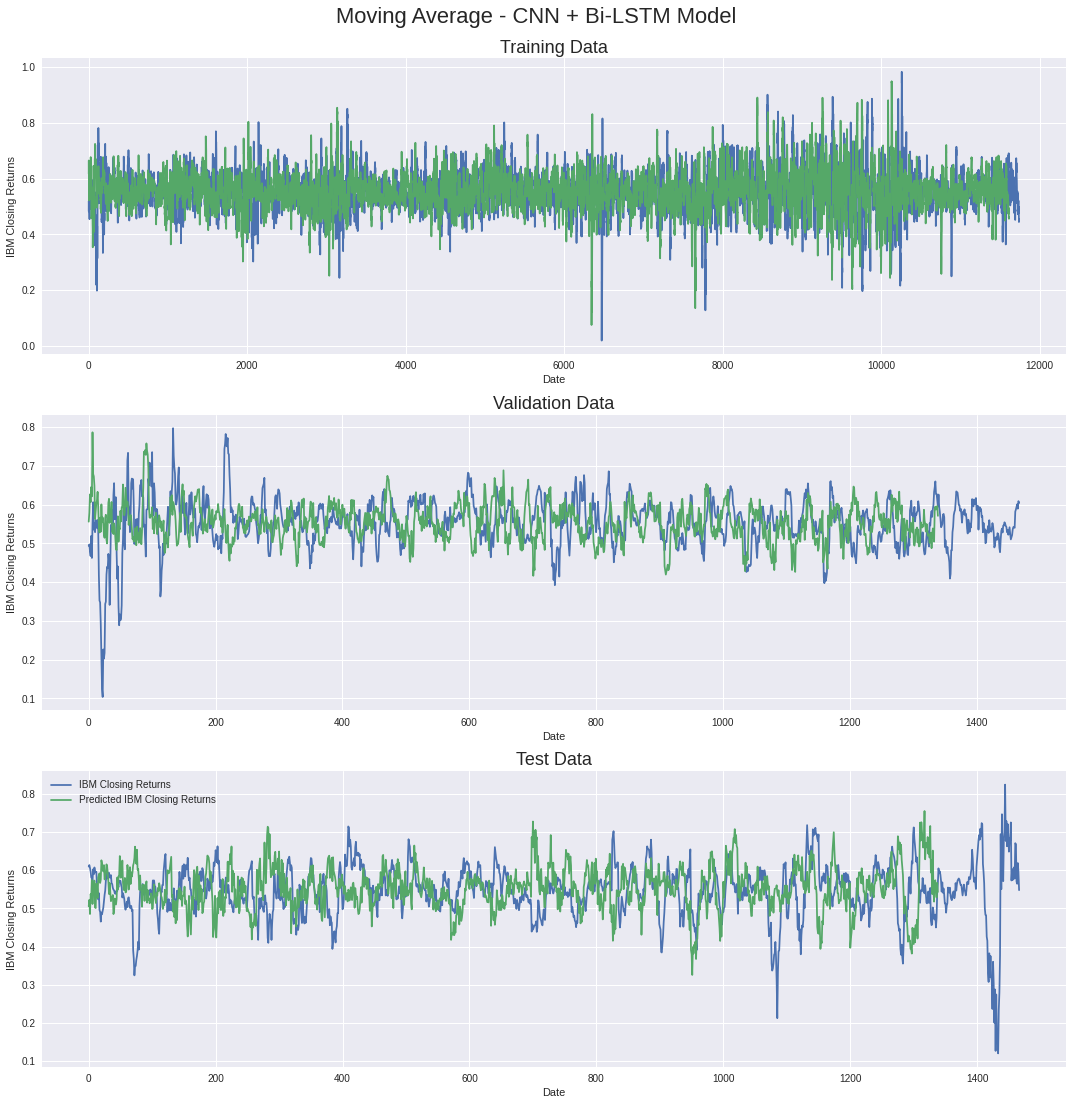

In [ ]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/CNN+Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

## **Conculsion 2**

As expected applying a moving average to the price data smoothed the return distribution and thus lead to an improved model performance.

However, when applying a moving average effect to a time series your dataset represent the real market less accurately. Subsequently, your dataset is biased towards less outliers.

When investing in the stock market it is curcial that outliers are not excluded or smoothed out since outliers majorly contribute to your trading performance.

Thus, any data transformations that can't be easily reverted once the predictions have been made, should be avoided. 

Nevertheless, seeing that a slight smoothing of the time series improved the error rates substantially for the Bi-LSTM model is a good thing to consider for future work.

In conculsion, I'll be looking for other prediction indicators which will be adding to the model's performance. 

*Next up are financial news...*


##### **Moving Average Bi-LSTM**
> Validation Data --> Loss: `0.0005`, MAE: `0.0170`, MAPE: `3.0885`

> Test Data --> Loss: `0.0009`, MAE: `0.0201`, MAPE: `4.0887`

##### **Bi-LSTM**
>Validation Data --> Loss: `0.0009`, MAE: `0.0211`, MAPE: `3.5828`

>Test Data --> Loss: `0.0014`, MAE: `0.0245`, MAPE: `4.2656`

---
---

##### **Moving Average CNN+Bi-LSTM**
>Validation Data --> Loss: `0.0008`, MAE: `0.0213`, MAPE: `3.8731`

>Test Data --> Loss: `0.0018`, MAE: `0.0292`, MAPE: `6.2077`

##### **CNN+Bi-LSTM**
>Validation Data --> Loss: `0.0010`, MAE: `0.0229`, MAPE: `3.8454`

>Test Data --> Loss: `0.0015`, MAE: `0.0264`, MAPE: `4.5289`